In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera

In [2]:
measurement_sigma = np.sqrt(0.5);
process_noise = np.sqrt(0.1);
sensor_locations = np.array([[0,0],[3000,3000]]);

In [3]:
class bearing():
    def __init__(self,sensor_no,bearing,time):
        self.sensor_no = sensor_no #can be 0 or 1
        self.sensor_location = np.array([[0,0],[3000,3000]])[sensor_no]
        self.bearing = bearing
        self.time = time
        self.track_id = 0 #for multiple target evaluations

In [4]:
initial_positions = np.array([100,200])
initial_velocities = np.array(5) #m/s
initial_orientation = np.array([335])
dx = initial_velocities * np.cos(np.deg2rad(90 - initial_orientation))
dy = initial_velocities * np.sin(np.deg2rad(90 - initial_orientation))
ts = 1
print(dx)
print(dy)



[-2.11309131]
[4.53153894]


In [5]:
A = lambda Ts: np.array([[1, 0, Ts, 0],[0, 1, 0, Ts], [0, 0, 1, 0],[0, 0, 0, 1]])
B = lambda ts: np.concatenate(((ts**2)*0.5*np.eye(2), ts * np.eye(2)), axis = 0)
aci = lambda konum, sensor_no: np.rad2deg(np.arctan2(konum[0] - sensor_locations[sensor_no][0], konum[1] - sensor_locations[sensor_no][1])) #x vey y ozellikle boyle (x,y)

In [6]:
temp_time_array = np.linspace(0,100,100 / ts)
time_array = np.sort(np.concatenate((temp_time_array, temp_time_array + np.random.rand(1,100) * 1/2), axis=None))
car_traj = [np.concatenate((initial_positions, dx, dy), axis=None)]
bearings = [bearing(0,aci(car_traj[0],0),time_array[0])]
for i in range(1,len(time_array)):
    car_traj.append((np.matmul(A(time_array[i]-time_array[i-1]),car_traj[-1].T).T + np.matmul(B(time_array[i]-time_array[i-1]), np.random.rand(2,1)).T * process_noise)[0])
coordinates = np.array(car_traj)[:,0:2]


In [7]:
for i in range(1,len(car_traj)):
    a = np.random.choice([False,True], p = [0.5,0.5])
    if a:
        bearings.append(bearing(0,aci(car_traj[i],0),time_array[i]))
    else:
        bearings.append(bearing(1,aci(car_traj[i],1),time_array[i])) 
        

In [8]:
bearings[0].bearing

26.56505117707799

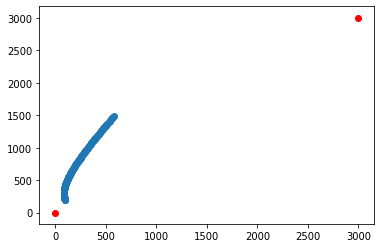

In [9]:
plt.scatter(coordinates[:,0],coordinates[:,1])
plt.scatter(sensor_locations[0][0],sensor_locations[0][1], c = "red")
plt.scatter(sensor_locations[1][0],sensor_locations[1][1], c = "red")

## Particle Filtering
We assume that we know initial point of the target.

In [10]:
N = 5000
h = lambda particles, bearing: 90 - (torch.atan2(particles[:,1] - bearing.sensor_location[1],particles[:,0] - bearing.sensor_location[0])* 57.295779513)
initial_state = torch.Tensor(car_traj[0])
initial_covarience_matrix = torch.diag(torch.Tensor([10**2,10**2,10,10]))
initial_sampling = torch.distributions.MultivariateNormal(loc= initial_state,covariance_matrix = initial_covarience_matrix)
particles = torch.squeeze(initial_sampling.expand([N, 1]).sample())
weights = torch.ones(N) / N

In [11]:
def residual_resample(weights):
    """ Performs the residual resampling algorithm used by particle filters.
    Based on observation that we don't need to use random numbers to select
    most of the weights. Take int(N*w^i) samples of each particle i, and then
    resample any remaining using a standard resampling algorithm [1]
    Parameters
    ----------
    weights : list-like of float
        list of weights as floats
    Returns
    -------
    indexes : ndarray of ints
        array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    References
    ----------
    .. [1] J. S. Liu and R. Chen. Sequential Monte Carlo methods for dynamic
       systems. Journal of the American Statistical Association,
       93(443):1032–1044, 1998.
    """

    N = len(weights)
    #indexes = np.zeros(N, 'i')
    indexes=torch.zeros(N,dtype=torch.int32)
    # take int(N*w) copies of each weight, which ensures particles with the
    # same weight are drawn uniformly
    #num_copies = (np.floor(N*np.asarray(weights))).astype(int)
    num_copies = (torch.floor(N*torch.as_tensor(weights))).int()
    k = 0
    for i in range(N):
        for _ in range(num_copies[i]): # make n copies
            indexes[k] = i
            k += 1

    # use multinormal resample on the residual to fill up the rest. This
    # maximizes the variance of the samples
    residual = weights - num_copies     # get fractional part
    residual /= sum(residual)           # normalize
    #cumulative_sum = np.cumsum(residual)
    cumulative_sum = torch.cumsum(residual,dim=0)
    cumulative_sum[-1] = 1. # avoid round-off errors: ensures sum is exactly one
    indexes[k:N] = np.searchsorted(cumulative_sum, random(N-k))

    return indexes



def stratified_resample(weights):
    """ Performs the stratified resampling algorithm used by particle filters.
    This algorithms aims to make selections relatively uniformly across the
    particles. It divides the cumulative sum of the weights into N equal
    divisions, and then selects one particle randomly from each division. This
    guarantees that each sample is between 0 and 2/N apart.
    Parameters
    ----------
    weights : list-like of float
        list of weights as floats
    Returns
    -------
    indexes : ndarray of ints
        array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    """

    N = len(weights)
    # make N subdivisions, and chose a random position within each one
    #positions = (random(N) + range(N)) / N
    positions = (torch.rand(N) + torch.arange(N)) / N

    #indexes = np.zeros(N, 'i')
    indexes=torch.zeros(N,dtype=torch.int32)
    #cumulative_sum = np.cumsum(weights)
    cumulative_sum = torch.cumsum(weights,dim=0)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes


def systematic_resample(weights):
    """ Performs the systemic resampling algorithm used by particle filters.
    This algorithm separates the sample space into N divisions. A single random
    offset is used to to choose where to sample from for all divisions. This
    guarantees that every sample is exactly 1/N apart.
    Parameters
    ----------
    weights : list-like of float
        list of weights as floats
    Returns
    -------
    indexes : ndarray of ints
        array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    """
    N = len(weights)

    # make N subdivisions, and choose positions with a consistent random offset
    #positions = (random() + np.arange(N)) / N
    positions = (torch.rand(1) + torch.arange(N)) / N

    #indexes = np.zeros(N, 'i')
    indexes=torch.zeros(N,dtype=torch.int32)
    #cumulative_sum = np.cumsum(weights)
    cumulative_sum = torch.cumsum(weights,dim=0)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

In [12]:
def update(particles, weights, bearing, sigma, h_func):
    v = bearing.bearing - h_func(particles,bearing)
    v[(v < -170) * (v > -190)] += 180 
    v[(v < -350) * (v > -370)] += 360
    v[(v < 190) * (v > 170)] -= 180
    v[(v < 370) * (v > 350)] -= 360
    weigths = weights * torch.distributions.normal.Normal(0,sigma).log_prob(v).exp()  
    weights = weigths + torch.Tensor([1.e-300])     # avoid round-off to zero
    weights = weigths / torch.sum(weights) # normalize
    return weights
    

In [13]:
def predict(particles, ts=torch.Tensor([1.])):
    """ 
    One step propagation. It is linear in Bearing-Only-Tracking.
    """
    particles = torch.matmul(particles,torch.t(torch.tensor(A(ts)).float())) 
    particles += torch.transpose(torch.mm(torch.Tensor(B(time_array[i]-time_array[i-1])),torch.empty([2,len(particles)]).normal_(mean=0,std=process_noise)),0,1)
    
    return particles

In [14]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""
    mean = torch.sum(torch.mul(particles,weights[None].transpose_(0, 1)),dim=0)
    var = torch.sum(torch.mul((particles - mean).pow(2),weights[None].transpose_(0, 1)),dim=0)
    return mean, var

In [15]:
def neff(weights):
    return 1. / torch.dot(weights,weights)

In [16]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes.long()]
    weights[:] = weights[indexes.long()]
    weights = torch.full(weights.shape, 1.0 / len(weights))
    print(weights)
    return weights,particles

tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])


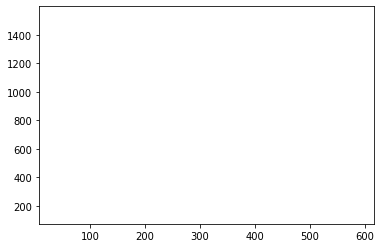

In [17]:
takip = []
plot = True
old_time = bearings[0].time
fig = plt.figure()
camera = Camera(fig)
for bearing in bearings[1:]:
    particles = predict(particles, ts = torch.Tensor([bearing.time - old_time]))
    weights = update(particles, weights, bearing, sigma = measurement_sigma, h_func = h)
    # resample if too few effective particles
    # resample if too few effective particles
    
    
    if neff(weights) < N/2:
        indexes = systematic_resample(weights)
        #print("--------------------")
        #print(weights)
        weights,particles=resample_from_index(particles, weights, indexes)
        #print("----------------------")
        #print(weights)
        #print("------------------------")
        #assert torch.allclose(weights, torch.full(1/N))
        #assert torch.allclose(weights, torch.full(weights.shape,1/N))
        
    mean, var = estimate(particles, weights)
    takip.append(mean)
    
    
    


    
        
   
    if plot:
            alpha = .20
            if N > 5000:
                alpha *= np.sqrt(5000)/np.sqrt(N)           
            plt.scatter(particles[:, 0], particles[:, 1], 
                        alpha=alpha, color='g')
    
    plt.scatter(coordinates[:,0], coordinates[:,1], marker='+',color='y', s=180, lw=3)
    plt.scatter(mean[0], mean[1], marker='+',color='r', s=180, lw=3)
    old_time = bearing.time
    camera.snap()
    
animation = camera.animate()
animation.save('deneme.gif')

In [ ]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

In [19]:
from PIL import Image
im = Image.open('deneme.gif')

In [20]:
im.